# Mini-Project 3 - Tripadvisor Hotel Review 

## 0. Define the stopwords

In [1]:
# custom_stop_words = ["hotel", "room", "day", "night", "time", "resort", "got",
#                     "people", "asked", "told", "thing", "really", "want", "food",
#                     "go", "stay", "come", "look", "say", "try", "think", "restaurant",
#                     "service", "good", "great", "nice", "place", "know", "little", "check", 
#                     "small", "bit", "beach", "big", "lot", "n't", "way", "close", "work", "need"]

custom_stop_words = ["hotel", "room", "day", "night", "time", "got",
                    "people", "asked", "told", "thing", "really", "want",
                    "go", "stay", "come", "look", "say", "try", "think",
                    "service", "nice", "place", "know", "little", "check", 
                    "small", "bit", "big", "lot", "n't", "way", "close", "work", "need"]

## 1. Import Libraries

In [2]:
## Import Libraries
import pandas as pd
import numpy as np

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc
)

import warnings
warnings.filterwarnings('ignore')

In [3]:
print(pd.__version__)
print(np.__version__)

2.2.2
1.26.4


## 2. Load Data

**Procedures**

1. Download the dataset from Tripadvisor hotel reviews (https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews).
2. Save the file in your local directory.

In [4]:
reviews_df = pd.read_csv("C:\\Users\\USER\\Documents\\aiap\\tripadvisor_hotel_reviews.csv")

In [5]:
reviews_df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
reviews_df.shape

(20491, 2)

In [7]:
# Data inspecton - missing values and datatype for each column

print(reviews_df.isnull().sum())
print(reviews_df.info())

Review    0
Rating    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None


In [8]:
# Let's define review sentiments - 1,2 = negative, 3 neutral and 4,5 = positive

# Assign sentiment based on the rating
reviews_df['sentiment'] = reviews_df['Rating'].apply(
    lambda x: -1 if x <= 2 else (0 if x == 3 else 1)
)

In [9]:
# Calculate ratings overview
ratings_overview_rating = reviews_df.Rating.value_counts(normalize=True) * 100
ratings_overview_sentiment = reviews_df.sentiment.value_counts(normalize=True) * 100

# Print the overviews
print("--" * 15)
print("Rating Overview:\n", ratings_overview_rating)
print("--" * 15)
print("Sentiment Overview:\n", ratings_overview_sentiment)
print("--" * 15)

------------------------------
Rating Overview:
 Rating
5    44.185252
4    29.471475
3    10.658338
2     8.750183
1     6.934752
Name: proportion, dtype: float64
------------------------------
Sentiment Overview:
 sentiment
 1    73.656727
-1    15.684935
 0    10.658338
Name: proportion, dtype: float64
------------------------------


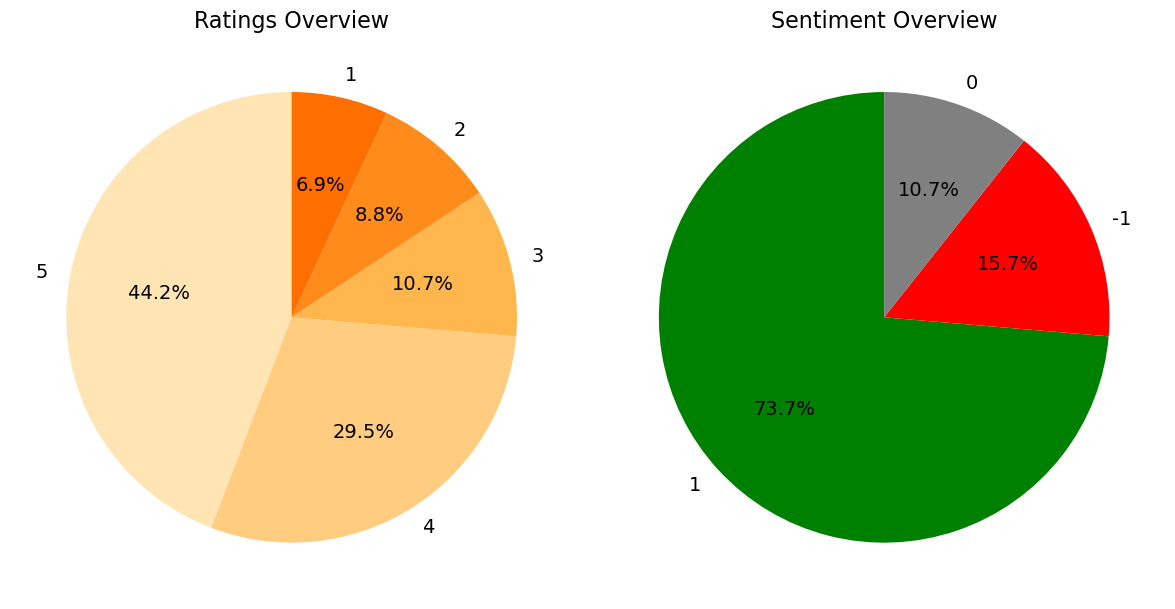

In [10]:
# Define custom colors
ratings_colors = ["#ffe5b4", "#ffcc80", "#ffb74d", "#ff8c1a", "#ff6f00"]  # Light to dark orange for 1-5
sentiment_colors = {-1: "red", 0: "grey", 1: "green"}

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for ratings
axes[0].pie(
    ratings_overview_rating, 
    labels=ratings_overview_rating.index, 
    autopct='%1.1f%%', 
    textprops={'fontsize': 14},
    startangle=90, 
    colors=ratings_colors
)
axes[0].set_title("Ratings Overview", fontsize=16)

axes[1].pie(
    ratings_overview_sentiment, 
    labels=ratings_overview_sentiment.index, 
    autopct='%1.1f%%', 
    textprops={'fontsize': 14},
    startangle=90, 
    colors=[sentiment_colors[label] for label in ratings_overview_sentiment.index]
)
axes[1].set_title("Sentiment Overview", fontsize=16)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("ratings_and_sentiment_overview_custom.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

In [11]:
# We need to concatenate the review string in order to generate the word cloud
reviews = reviews_df['Review'].str.cat(sep=' ')

reviews[:500]

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, loc'

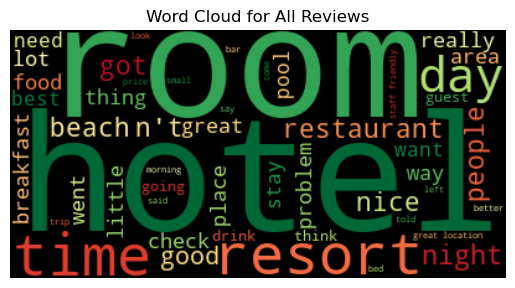

CPU times: total: 11.5 s
Wall time: 13.5 s


In [12]:
%%time
from wordcloud import WordCloud

cloud = WordCloud(max_words=50, background_color='black', colormap='RdYlGn',
                  normalize_plurals=True)

cloud.generate(reviews)

plt.imshow(cloud, interpolation='bilinear')  # Render the word cloud image
plt.axis('off')  # Hide axes
plt.title('Word Cloud for All Reviews')
plt.show()

In [13]:
# Delete the reviews variable to free the memory
del reviews

## 3. Data Cleaning

### Define the helper function for data cleaning

1. Cleans the text data
2. Performs lemmatization

In [14]:
import re

# Load spaCy's English model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

batch_size = 5000

In [15]:
from nltk.tokenize import word_tokenize

def preprocess_text(df, text_col="Review", custom_stop_words=custom_stop_words):
    """
    Function to clean the text and assign clean text into a new column using the nlp pipeline.
    """
    
    # Add custom stop words to spaCy's stop words list
    for word in custom_stop_words:
        nlp.vocab[word].is_stop = True

    # Remove digits
    df[text_col] = df[text_col].str.replace(r'\d+', '', regex=True)

    # Step 1: Build an NLP pipe
    nlp_pipe = nlp.pipe(df[text_col], batch_size=batch_size, disable=["ner", "parser"])

    # Step 2: Remove punctuation, stopwords, and then lemmatization
    tokens = []
    for doc in nlp_pipe:
        # Filter out punctuation and stop words
        filtered_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
        tokens.append(filtered_tokens)
    
    # Filtering out custom stop words (lemmas)
    filtered_tokens = [[token for token in doc if token not in custom_stop_words] 
                       for doc in tokens]
    
    # Join tokens to create a cleaned text column
    df['processed_reviews'] = [' '.join(token) for token in filtered_tokens]

    return df

# Sample text
# sample_text_series = pd.Series({'Review': ["She nicely made a created a plan and will execute it."]})
sample_text_series = pd.DataFrame({'Review': ["what nice hotel rooms with a pleasant view.", 
                                              "not a good restaurant to dine at, waiter is terrible."]})

# Demonstration usage - test the function on the sample text
words_lemmatized = preprocess_text(sample_text_series)
pd.DataFrame(words_lemmatized)


,Review,processed_reviews
0,what nice hotel rooms with a pleasant view.,pleasant view
1,"not a good restaurant to dine at, waiter is te...",good restaurant dine waiter terrible


In [16]:
%%time

preprocess_text(reviews_df, text_col='Review')

CPU times: total: 2min 29s
Wall time: 2min 33s


,Review,Rating,sentiment,processed_reviews
0,nice hotel expensive parking got good deal sta...,4,1,expensive parking good deal anniversary arrive...
1,ok nothing special charge diamond member hilto...,2,-1,ok special charge diamond member hilton decide...
2,nice rooms not * experience hotel monaco seatt...,3,0,experience monaco seattle good level.positive ...
3,"unique, great stay, wonderful time hotel monac...",5,1,unique great wonderful monaco location excelle...
4,"great stay great stay, went seahawk game aweso...",5,1,great great seahawk game awesome downfall view...
...,...,...,...,...
20486,"best kept secret rd time staying charm, not -s...",5,1,well keep secret rd charm -star beat increase ...
20487,great location price view hotel great quick pl...,4,1,great location price view great quick sights.d...
20488,"ok just looks nice modern outside, desk staff ...",2,-1,ok modern outside desk staff particularly frie...
20489,hotel theft ruined vacation hotel opened sept ...,1,-1,theft ruin vacation open sept guest week ha...


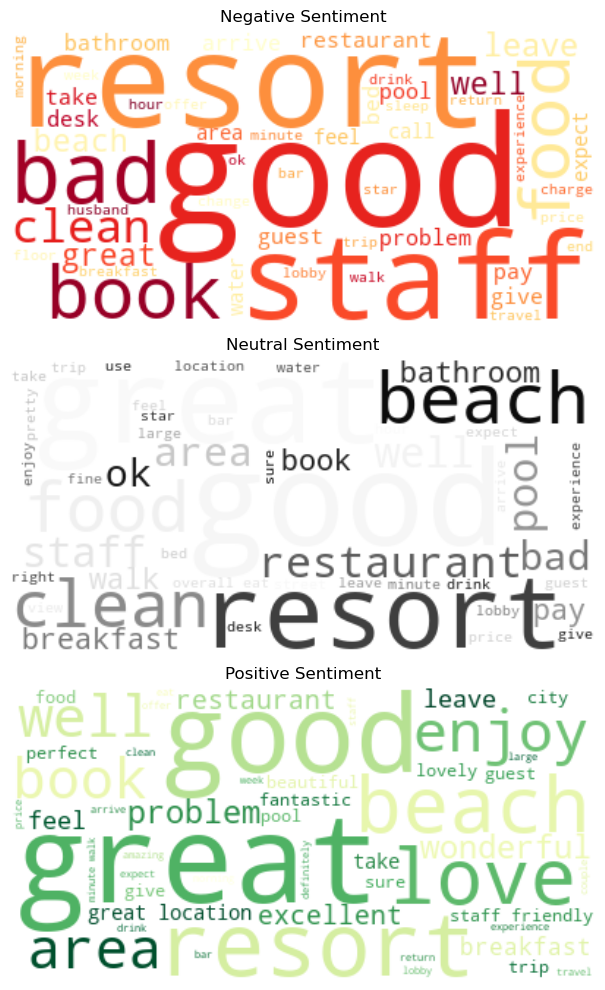

CPU times: total: 11.5 s
Wall time: 12.8 s


In [17]:
%%time
# Create subplots for visualizing word clouds
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Sentiment categories
sentiments = { -1: "Negative Sentiment", 0: "Neutral Sentiment", 1: "Positive Sentiment" }
colormap_list = ["YlOrRd", "Greys", "YlGn"]

# Generate word clouds for each sentiment in a loop
for i, (sentiment, title) in enumerate(sentiments.items()):
    reviews = reviews_df.loc[reviews_df['sentiment'] == sentiment, 'processed_reviews'].str.cat(sep=' ')
    word_cloud = WordCloud(max_words=50, normalize_plurals=True,
                           colormap=colormap_list[i], background_color='white').generate(reviews)

    # Save word cloud to a file
    word_cloud.to_file(f"word_cloud_{sentiment}.png")
    
    ax[i].imshow(word_cloud, interpolation='bilinear')  # Render the word cloud image
    ax[i].axis('off')  # Hide axes
    ax[i].set_title(title)  # Set title

plt.tight_layout()  # Adjust spacing
plt.show()
plt.savefig("wordclouds.png")

## 4. Perform train-test split

In [18]:
X = reviews_df['processed_reviews']
y = reviews_df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. Feature Extraction or vectorization


In [19]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=500,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))

In [20]:
%%time
# Fit and transform the processed reviews to create a TF-IDF matrix
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

print(X_train_tfidf.shape)

(16392, 93)
CPU times: total: 10.9 s
Wall time: 11.3 s


## 6. Unsupervised Learning

### 6.1 Principal Component Analysis

In [21]:
from sklearn.decomposition import PCA

In [22]:
n_components = 10

In [23]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

pca = PCA(n_components=n_components)
train_X_pca = pca.fit_transform(X_train_tfidf)
test_X_pca = pca.transform(X_test_tfidf)

<Figure size 640x480 with 0 Axes>

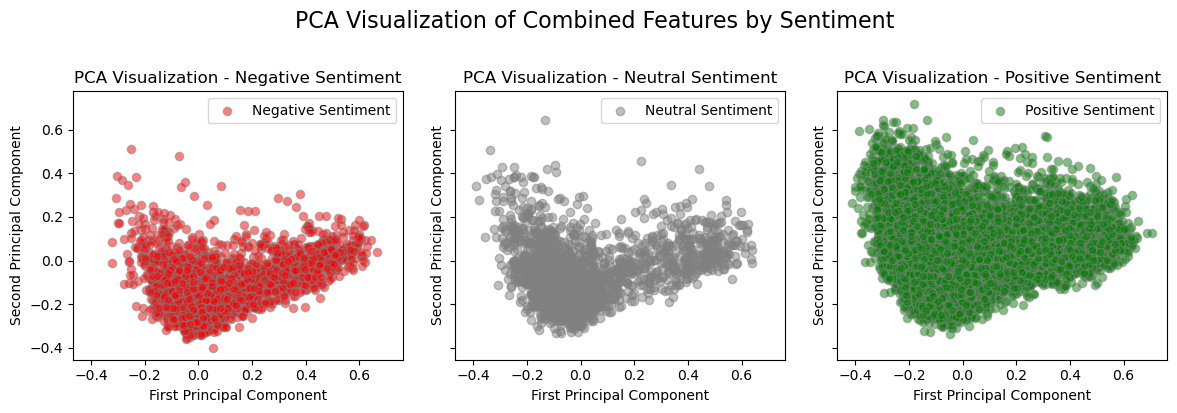

In [24]:
# Create two subplots for the two sentiments
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# Sentiments
sentiments = [-1, 0, 1]
sentiment_labels = ["Negative Sentiment", "Neutral Sentiment", "Positive Sentiment"]
palette = ["red", "grey", "green"]

for i, sentiment in enumerate(sentiments):
    sentiment_mask = (y_train == sentiment)
    ax[i].scatter(
        train_X_pca[sentiment_mask, 0],
        train_X_pca[sentiment_mask, 1],
        alpha=0.5,
        color=palette[i],
        edgecolor='grey',
        label=sentiment_labels[i]
    )
    ax[i].set_title(f"PCA Visualization - {sentiment_labels[i]}")
    ax[i].set_xlabel("First Principal Component")
    ax[i].set_ylabel("Second Principal Component")
    ax[i].legend()

plt.suptitle("PCA Visualization of Combined Features by Sentiment", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("pca_sentiment_analysis.png", dpi=200)
plt.show()


In [25]:
# Helper functions from Lab 6.4
def calculate_cum_var_exp(eig_vals):
    tot = sum(eig_vals)
    #var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    #var_exp = [(i / tot)*100 for i in eig_vals]
    var_exp = []
    for i in eig_vals:
        var_i = (i / tot)*100
        var_exp.append(var_i)
    cum_var_exp = np.cumsum(var_exp)
    return cum_var_exp

total_variance = pca.explained_variance_.sum()
pca_variance = list(zip(range(1, len(pca.explained_variance_) + 1), (100 * pca.explained_variance_/total_variance)))
cum_pca_variance= calculate_cum_var_exp(pca.explained_variance_)

cum_pca_variance

array([ 21.41618396,  34.4133904 ,  44.94935526,  54.80205297,
        63.45399111,  71.36028699,  78.99713231,  86.13528972,
        93.11589589, 100.        ])

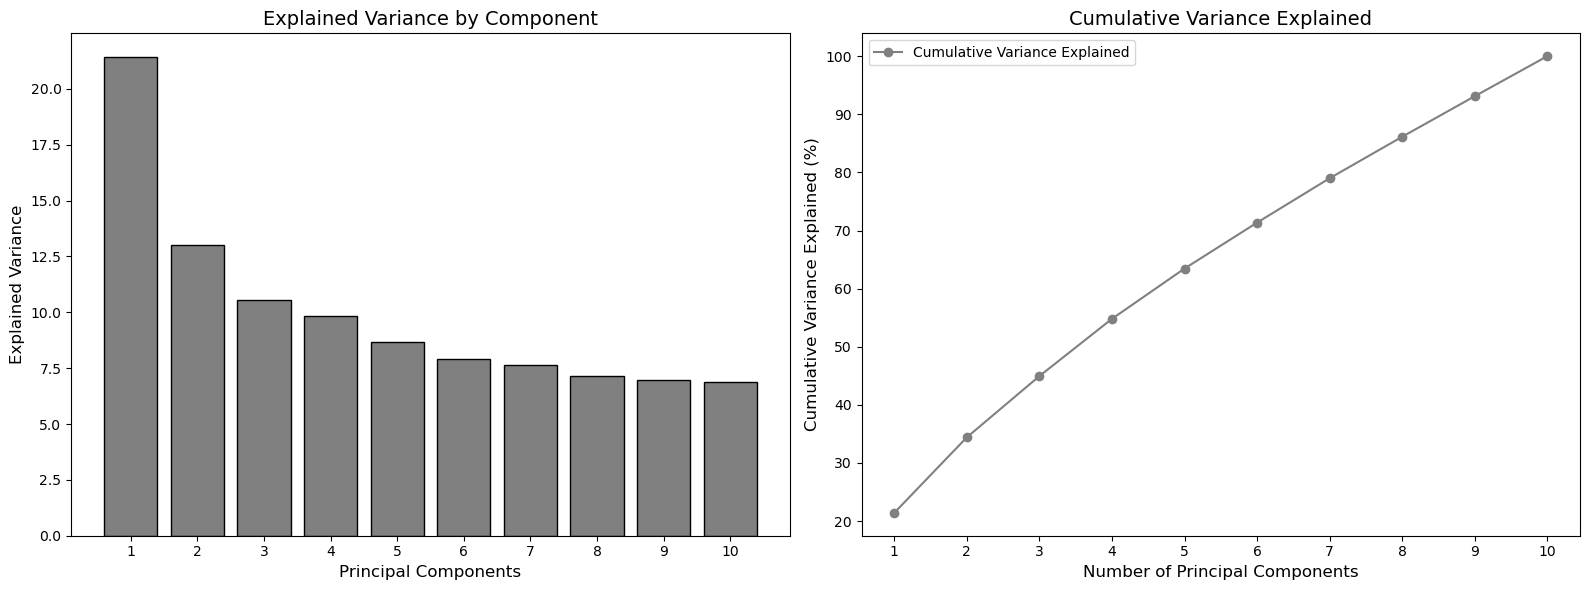

In [26]:
# Unpack the principal components and their explained variance
components, explained_variance = zip(*pca_variance)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram of explained variance ratios
axes[0].bar(components, explained_variance, color='grey', edgecolor='black')
axes[0].set_xlabel('Principal Components', fontsize=12)
axes[0].set_ylabel('Explained Variance', fontsize=12)
axes[0].set_title('Explained Variance by Component', fontsize=14)
axes[0].set_xticks(components)

# Plot 2: Plot cumulative variance explained vs number of components
axes[1].plot(
    range(1, n_components+1),  # Adjust based on the number of components
    (cum_pca_variance),  # Matching cumulative variance formula
    marker='o',
    linestyle='-',
    color='grey',
    label='Cumulative Variance Explained'
)
axes[1].set_xlabel('Number of Principal Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14)
axes[1].tick_params(axis='both', labelsize=10)
axes[1].set_xticks(np.arange(1, n_components + 1, 1))
axes[1].legend(fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("principal_component_analysis.png", dpi=200)
plt.show()

In [27]:
# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

In [28]:
# Number of top words to display for each principal component
n_top_words = 10

# Assuming 'pca.components_' contains the principal components and 'vocab' is the list of feature names (words)
# pca.components_ will have shape (n_components, n_features)

# Create a list to store summaries for each principal component
component_summaries = []

print('Principal Component Top Words')
print('-----', '-'*80)

# Iterate through each principal component
for i, component in enumerate(pca.components_):
    # Sort the words by their importance (loadings) for this principal component
    top_word_indices = np.argsort(np.abs(component))[::-1][:n_top_words]  # Get indices of top n words
    top_words = feature_names[top_word_indices]  # Get the actual words using the indices
    component_summaries.append(' '.join(top_words))

    # Print out the top words for the component
    print('  %3d %s' % (i, ' '.join(top_words)))

Principal Component Top Words
----- --------------------------------------------------------------------------------
    0 resort beach location pool food water drink great location beautiful helpful
    1 great great location location beach bed resort floor desk pay bathroom
    2 good wonderful location walk breakfast restaurant staff love bar price
    3 great excellent staff friendly helpful good bed staff friendly floor view
    4 walk good minute area restaurant bad station star city beach
    5 view excellent walk minute floor good resort clean th station
    6 excellent friendly bed location staff friendly clean staff comfortable helpful city
    7 bed excellent comfortable location good resort city bathroom view large
    8 love excellent wonderful perfect good staff location friendly great book
    9 view resort floor excellent breakfast location th restaurant bar like


### 6.2 K-means clustering

In [29]:
# Adapted from Lab 6.1
from sklearn.cluster import KMeans

# Function to plot the data and centroids
def plot_data(ax, X, y, centroids, show_clusters=True):
    a, b = centroids[:, 0], centroids[:, 1]  # Unpack centroid coordinates

    if show_clusters:
        colours = 'rgbycm'
        for i in np.unique(y):
            ax.scatter(
                X[y == i, 0], X[y == i, 1],
                c=colours[i % len(colours)],
                label=f'Cluster {i}',
                edgecolor='grey',
                alpha = 0.3
            )
    else:
        ax.scatter(X[:, 0], X[:, 1], c='pink',
                   alpha= 0.5, edgecolor='grey', label='Data Points')

    ax.scatter(a, b, c='k', marker='x', s=100, label='Centroids')  # Plot centroids
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.legend()

In [30]:
# Calculate variance for different numbers of clusters
variances = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_tfidf.toarray())
    variances.append(kmeans.inertia_)

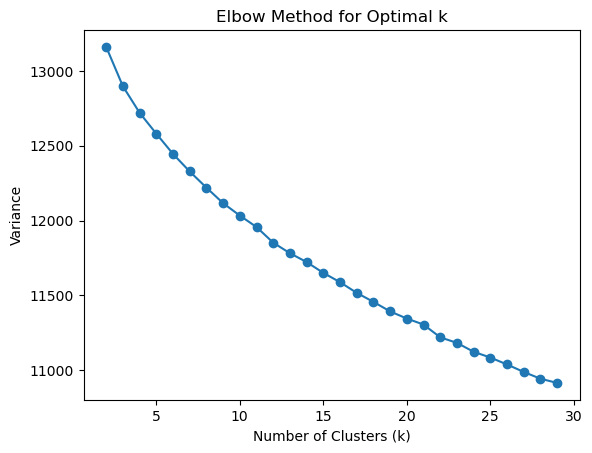

In [31]:
# Plot the elbow curve
plt.plot(range(2, 30), variances, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Variance')
plt.show()

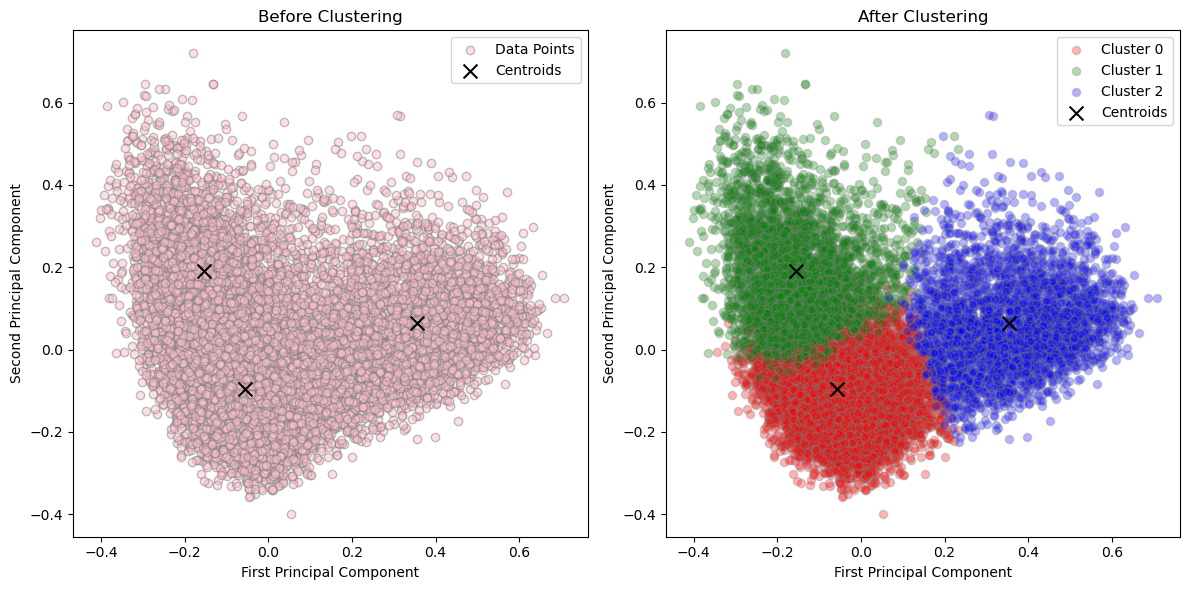

In [32]:
# Number of clusters
K = 3

# Apply KMeans from sklearn
kmeans = KMeans(n_clusters=K, random_state=42)
y_kmeans = kmeans.fit_predict(train_X_pca)
centroids = kmeans.cluster_centers_

# Plot the initial state and final state
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Before clustering (raw data)
plot_data(axes[0], train_X_pca, np.zeros(train_X_pca.shape[0]), kmeans.cluster_centers_, False)
axes[0].set_title('Before Clustering')

# After clustering
plot_data(axes[1], train_X_pca, y_kmeans, centroids)
axes[1].set_title('After Clustering')

plt.tight_layout()
plt.savefig("pca_kmeans.png", dpi=200)
plt.show()

### 6.3 DBSCAN clustering [POOR RESULTS - ignore]

In [33]:
from sklearn.cluster import DBSCAN

# Function to plot data and noise
def plot_data_dbscan(ax, X, y, show_clusters=True):
    unique_labels = set(y)
    colours = 'rgbycm'

    for i, label in enumerate(unique_labels):
        if label == -1:  # Noise
            continue
            # ax.scatter(
            #     X[y == label, 0], X[y == label, 1],
            #     c='k', marker='x', label='Noise',
            #     alpha=0.5
            # )
        else:  # Cluster points
            ax.scatter(
                X[y == label, 0], X[y == label, 1],
                label=f'Cluster {label}',
                cmap=colours[i % len(colours)],
                alpha=0.3
            )

    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.legend(loc='best')

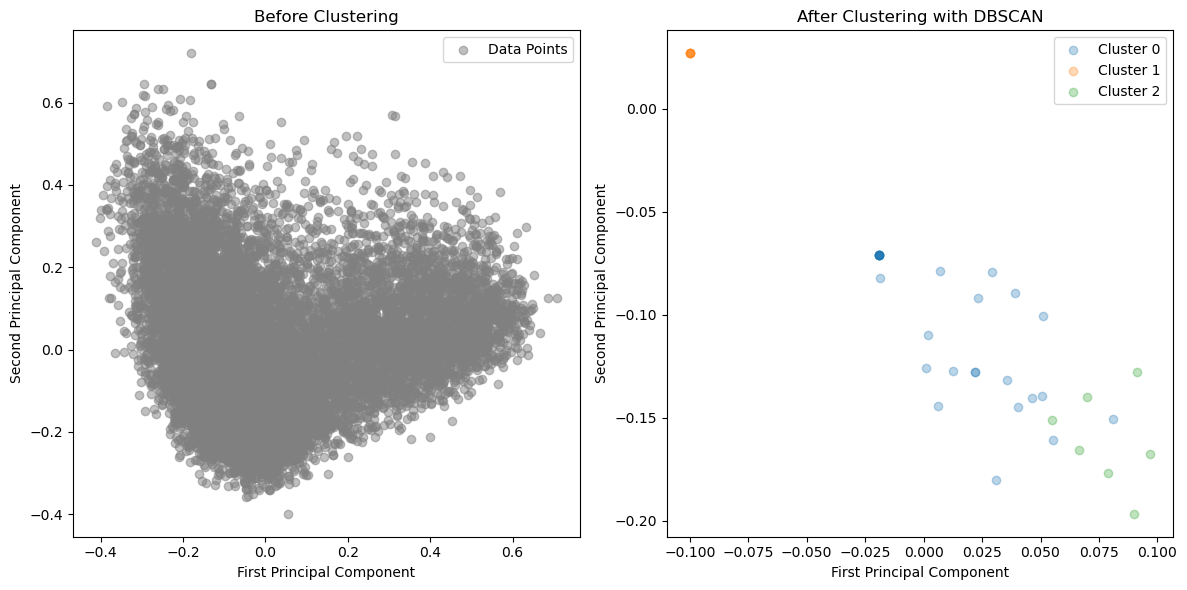

In [34]:
# Apply DBSCAN - TODO: play with eps parameter to get the clusters
dbscan = DBSCAN(eps=0.08, min_samples=5)
y_dbscan = dbscan.fit_predict(train_X_pca)

# DBSCAN only has the cluster labels and noise (-1)

# Visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Before clustering (raw data)
axes[0].scatter(train_X_pca[:, 0], train_X_pca[:, 1], c='gray', alpha=0.5, label='Data Points')
axes[0].set_title('Before Clustering')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].legend()

# After clustering (DBSCAN results)
plot_data_dbscan(axes[1], train_X_pca, y_dbscan)
axes[1].set_title('After Clustering with DBSCAN')

plt.tight_layout()
plt.show()

### 6.4 Topic Modeling

Adapted and changed code from this repo.

(https://github.com/rollyjohn/Topic-Modelling/blob/main/topic_model_V3.ipynb?fbclid=IwZXh0bgNhZW0CMTAAAR2Iw-KoPY1BjGQgBPmvv7x324m-6juHJgFVO7RTtz7C60gGf7oAZ5wJhlI_aem_vGREf6PLWVVqWcd72EyB6Q)

In [35]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# package to print
from pprint import pprint

#### 6.4.1 Tokenize processed reviews

In [36]:
from nltk.tokenize import word_tokenize

reviews_df["processed_review_tokens"] = reviews_df["processed_reviews"].apply(word_tokenize)

#### 6.4.2 Prepare dictionary and corpus for topic modeling

In [37]:
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus
# Create the Dictionary and Corpus needed for Topic Modelling

#  Dictionary
id2word = corpora.Dictionary(reviews_df.processed_review_tokens)

#  Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in reviews_df.processed_review_tokens]

#### 6.4.3 Fit LDA model

In [38]:
%%time
n = 4 # decided to start with 4 topics. There are advanced approaches like Kullback Leibler Divergence
                                                              # to obtain the optimal number of topics.

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Look at the topics and key words
pprint(lda_model.print_topics())

[(0,
  '0.038*"not" + 0.019*"pm" + 0.014*"guy" + 0.014*"property" + 0.013*"key" + '
  '0.012*"phone" + 0.012*"let" + 0.012*"card" + 0.011*"train" + '
  '0.010*"wedding"'),
 (1,
  '0.043*"beach" + 0.034*"pool" + 0.032*"resort" + 0.029*"food" + 0.015*"good" '
  '+ 0.015*"drink" + 0.013*"bar" + 0.012*"beautiful" + 0.011*"punta" + '
  '0.011*"cana"'),
 (2,
  '0.023*"great" + 0.018*"good" + 0.015*"staff" + 0.012*"clean" + 0.011*"walk" '
  '+ 0.010*"restaurant" + 0.010*"location" + 0.010*"breakfast" + 0.008*"area" '
  '+ 0.007*"excellent"'),
 (3,
  '0.014*"water" + 0.013*"leave" + 0.010*"problem" + 0.010*"like" + '
  '0.009*"bad" + 0.009*"desk" + 0.009*"hour" + 0.009*"take" + 0.008*"pay" + '
  '0.008*"guest"')]
CPU times: total: 13min 37s
Wall time: 13min 25s


#### 6.4.4 Calculate the topic distribution

In [39]:
def topics_per_review(model, corpus):
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus):
        topic_percs, _, _ = model[corp]
        dominant_topic = max(topic_percs, key=lambda x: x[1])[0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_review(model=lda_model, corpus=corpus)

In [40]:
topic_percentages_df = pd.DataFrame([
    {topic: prob for topic, prob in doc} for doc in topic_percentages
]).fillna(0)

dominant_topics_df = pd.DataFrame(dominant_topics, 
                                  columns=["index", "topic"]).set_index("index")

topics_df = pd.merge(dominant_topics_df, topic_percentages_df,
                     left_index=True, right_index=True, how="left")

# Ensure column order is correct
topic_df = topics_df.loc[:, ["topic"] + list(range(n))]

# Display the resulting DataFrame
display(topic_df)

,topic,0,1,2,3
index,,,,,
0,2,0.000000,0.000000,0.699758,0.292133
1,2,0.206896,0.000000,0.470427,0.321325
2,2,0.043298,0.013722,0.582692,0.360288
3,2,0.000000,0.000000,0.768449,0.223714
4,2,0.032545,0.061183,0.482569,0.423703
...,...,...,...,...,...
20486,2,0.056884,0.000000,0.790045,0.150319
20487,2,0.000000,0.000000,0.978104,0.000000
20488,2,0.080069,0.000000,0.659137,0.255723


In [41]:
# Breakdown of revivews by Topics
topic_df.topic.value_counts()

topic
2    17639
3     1812
1     1023
0       17
Name: count, dtype: int64

In [42]:
# Top n words per topic
top_n_words = 10

# Top Keywords for Each Topic
topic_top_words = [
    (topic_id, word) 
    for topic_id, topic in lda_model.show_topics(formatted=False) 
    for word, _ in topic[:top_n_words]
]

# Create DataFrame for top words
df_top_words = (
    pd.DataFrame(topic_top_words, columns=['topic_id', 'words'])
    .groupby('topic_id')['words']
    .apply(', '.join)  # Combine words for each topic
    .reset_index()
)

display(df_top_words)

,topic_id,words
0,0,"not, pm, guy, property, key, phone, let, card,..."
1,1,"beach, pool, resort, food, good, drink, bar, b..."
2,2,"great, good, staff, clean, walk, restaurant, l..."
3,3,"water, leave, problem, like, bad, desk, hour, ..."


In [43]:
print(df_top_words.words[3])

water, leave, problem, like, bad, desk, hour, take, pay, guest


In [44]:
df_topic_weightage_by_rev = topic_percentages_df.sum().reset_index().sort_values(by='index', ascending=True)
df_topic_weightage_by_rev.columns = ["Dominant_Topic", "count"]
display(df_topic_weightage_by_rev)

df_dominant_topic_in_each_rev = dominant_topics_df.value_counts().reset_index()
df_dominant_topic_in_each_rev.columns = ["Dominant_Topic", "count"]
df_dominant_topic_in_each_rev.sort_values(by="Dominant_Topic", ascending=True, inplace=True)

display(df_dominant_topic_in_each_rev)

,Dominant_Topic,count
2,0,1054.191838
3,1,1806.963972
0,2,13781.572875
1,3,3772.357293


,Dominant_Topic,count
3,0,17
2,1,1023
0,2,17639
1,3,1812


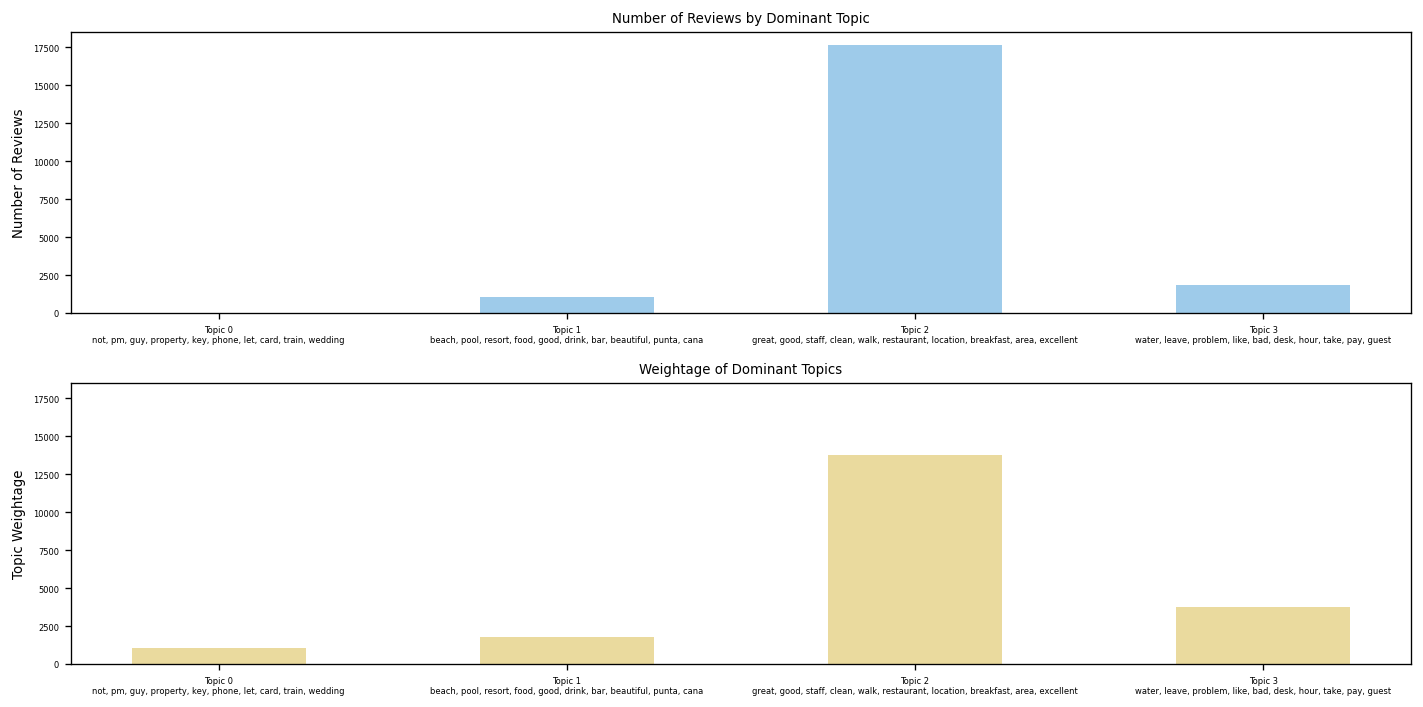

In [45]:
from matplotlib.ticker import FuncFormatter

# Custom Tick Formatter for Topics
def topic_tick_formatter(x, _):
    try:
        return f"Topic {int(x)}\n{df_top_words.loc[df_top_words.topic_id == int(x), 'words'].values[0]}"
    except IndexError:
        return f"Topic {int(x)}"

# Initialize tick formatter
tick_formatter = FuncFormatter(topic_tick_formatter)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=120, sharey=True)

# Plot 1: Topic Distribution by Dominant Topics
axes[0].bar(
    x=df_dominant_topic_in_each_rev['Dominant_Topic'], 
    height=df_dominant_topic_in_each_rev['count'], 
    width=0.5, 
    color='#9ECBEA'
)

axes[0].set_xticks(df_dominant_topic_in_each_rev['Dominant_Topic'].unique())
axes[0].xaxis.set_major_formatter(tick_formatter)
axes[0].tick_params(labelsize=5)
axes[0].set_title('Number of Reviews by Dominant Topic', fontsize=8)
axes[0].set_ylabel('Number of Reviews', fontsize=8)

# Plot 2: Topic Distribution by Topic Weights
axes[1].bar(
    x=df_topic_weightage_by_rev['Dominant_Topic'], 
    height=df_topic_weightage_by_rev['count'], 
    width=0.5, 
    color='#EADA9E'
)

axes[1].set_xticks(df_topic_weightage_by_rev['Dominant_Topic'].unique())
axes[1].xaxis.set_major_formatter(tick_formatter)
axes[1].tick_params(labelsize=5)
axes[1].set_title('Weightage of Dominant Topics', fontsize=8)
axes[1].set_ylabel('Topic Weightage', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.savefig("dominant_topic_count.png", dpi=200)
plt.show()


In [46]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=reviews_df["processed_review_tokens"],
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.205934276735318

Coherence Score:  0.35890431699409736


In [47]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output list
    sent_topics = []

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: x[1], reverse=True)

        # Extract the dominant topic and related information
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, _ in wp])

        sent_topics.append([int(topic_num), round(prop_topic, 4), topic_keywords])

    # Create DataFrame with topic information
    sent_topics_df = pd.DataFrame(sent_topics, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    
    # Add original text to the end of the DataFrame
    sent_topics_df['plot'] = texts

    return sent_topics_df

# Apply the function
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, 
                                                  corpus=corpus, texts=reviews_df['Review'])

# Reset index and rename columns
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Review']

In [48]:
df_dominant_topic[["Keywords", "Review"]]

,Keywords,Review
0,"great, good, staff, clean, walk, restaurant, l...",nice hotel expensive parking got good deal sta...
1,"great, good, staff, clean, walk, restaurant, l...",ok nothing special charge diamond member hilto...
2,"great, good, staff, clean, walk, restaurant, l...",nice rooms not * experience hotel monaco seatt...
3,"great, good, staff, clean, walk, restaurant, l...","unique, great stay, wonderful time hotel monac..."
4,"great, good, staff, clean, walk, restaurant, l...","great stay great stay, went seahawk game aweso..."
...,...,...
20486,"great, good, staff, clean, walk, restaurant, l...","best kept secret rd time staying charm, not -s..."
20487,"great, good, staff, clean, walk, restaurant, l...",great location price view hotel great quick pl...
20488,"great, good, staff, clean, walk, restaurant, l...","ok just looks nice modern outside, desk staff ..."
20489,"water, leave, problem, like, bad, desk, hour, ...",hotel theft ruined vacation hotel opened sept ...


In [49]:
df_dominant_topic["Review"][20489]

"hotel theft ruined vacation hotel opened sept   guests week, happy stumble scouting hotels apt stay booked gobcn- commented post unexpectedly cancelled arrival stuck place stay la merce festival barcelona biggest year, like trying hotel times square new year eve, vacancies hotel . new . not ready guests, new, hotel towels straight factory not washed pilling shower, not ready, entire week sept   slept proper blanket comforter n't arrived, got chilly night gave fleece throw supplied sister hotel ciutat barcelona hotel lime green colour scheme red black white spare cold, drawback double beds singles adjoined n't bothered hotels linens separately fish sheets order sleep couple fall lie middle, beds hard firm so-so quality foam pillows, best qualities hotel location close las ramblas hear street noise somewhat walkable attractions bari gottic, designed clean stylish hotel not clean  rooms construction things like cement drippings not scraped linoleum floor room etc., importantly room safe 

In [50]:
df_dominant_topic["Keywords"][20489]

'water, leave, problem, like, bad, desk, hour, take, pay, guest'

In [51]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.206237 -0.050474       1        1  58.994292
3      0.206180  0.179090       2        1  21.661535
1     -0.098919 -0.311474       3        1  13.484748
0     -0.313498  0.182858       4        1   5.859426, topic_info=         Term          Freq         Total Category  logprob  loglift
5184    beach   9563.000000   9563.000000  Default  30.0000  30.0000
1022     pool   9028.000000   9028.000000  Default  29.0000  29.0000
435      food   9851.000000   9851.000000  Default  28.0000  28.0000
5123   resort   7305.000000   7305.000000  Default  27.0000  27.0000
22      great  22352.000000  22352.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
475   wedding    968.009582   1519.461373   Topic4  -4.6146   2.3862
914     ready    850.105631   1524.882573   Topic4  -4.7445   2.2528
2024      buy    475.315695    857.058045   Topic4  -5.3259   2.2476
180      sure    579.291018   3032.320306   Topic4  -5.1281   1.1818
145        ok    482.737001   2265.518254   Topic4  -5.3104   1.2910

[214 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
328       3  0.999302   activity
1084      2  0.999607        air
1279      4  0.998567     appear
286       1  0.999876       area
3         1  0.440856     arrive
...     ...       ...        ...
1929      4  0.997608     wonder
326       1  0.999751  wonderful
838       2  0.999602      wrong
790       1  0.583425       year
790       3  0.416480       year

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

**Putting everything together for topic modeling**

Let us join the reviews table to the topic dataframes.

In [52]:
A = pd.merge(reviews_df, topic_df, left_index=True, right_index=True, how="left")

A.head()

,Review,Rating,sentiment,processed_reviews,processed_review_tokens,topic,0,1,2,3
0,nice hotel expensive parking got good deal sta...,4,1,expensive parking good deal anniversary arrive...,"[expensive, parking, good, deal, anniversary, ...",2,0.000000,0.000000,0.699758,0.292133
1,ok nothing special charge diamond member hilto...,2,-1,ok special charge diamond member hilton decide...,"[ok, special, charge, diamond, member, hilton,...",2,0.206896,0.000000,0.470427,0.321325
2,nice rooms not * experience hotel monaco seatt...,3,0,experience monaco seattle good level.positive ...,"[experience, monaco, seattle, good, level.posi...",2,0.043298,0.013722,0.582692,0.360288
3,"unique, great stay, wonderful time hotel monac...",5,1,unique great wonderful monaco location excelle...,"[unique, great, wonderful, monaco, location, e...",2,0.000000,0.000000,0.768449,0.223714
4,"great stay great stay, went seahawk game aweso...",5,1,great great seahawk game awesome downfall view...,"[great, great, seahawk, game, awesome, downfal...",2,0.032545,0.061183,0.482569,0.423703


------------------------------
% Review breakdown by Rating for Topic 0:
Rating
1    35.294118
3    23.529412
2    17.647059
5    11.764706
4    11.764706
Name: proportion, dtype: float64

------------------------------
% Review breakdown by Rating for Topic 1:
Rating
5    41.251222
4    33.235582
3    12.805474
2     9.872923
1     2.834800
Name: proportion, dtype: float64

------------------------------
% Review breakdown by Rating for Topic 2:
Rating
5    48.596859
4    31.583423
3    10.561823
2     6.338228
1     2.919667
Name: proportion, dtype: float64

------------------------------
% Review breakdown by Rating for Topic 3:
Rating
1    48.068433
2    31.512141
3    10.264901
4     6.953642
5     3.200883
Name: proportion, dtype: float64

------------------------------


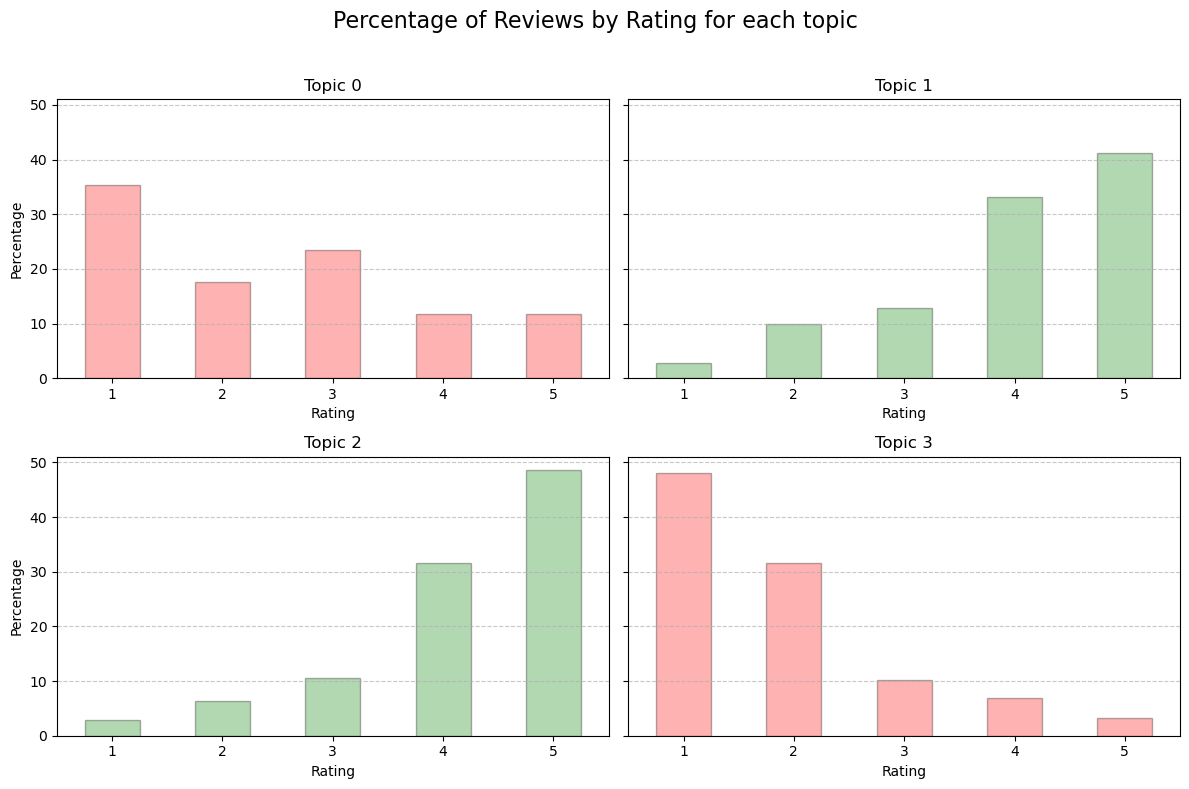

In [53]:
# Print breakdown by rating for each topic
print("--" * 15)
for i in range(4):  # Assuming topics are numbered 0 to 3
    breakdown = A[A["topic"] == i]["Rating"].value_counts(normalize=True) * 100
    print(f"% Review breakdown by Rating for Topic {i}:\n{breakdown}\n")
    print("--" * 15)

# Visualization of the breakdown
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

# set the bar color according to sentiment of topics
color_list = ["red", "green", "green", "red"]

for i, ax in enumerate(axes.flatten()):
    breakdown = A[A["topic"] == i]["Rating"].value_counts(normalize=True) * 100
    breakdown = breakdown.sort_index()  # Ensuring ratings are in order
    breakdown.plot(kind="bar", ax=ax, color=color_list[i], edgecolor="black", alpha=0.3)
    ax.set_title(f"Topic {i}")
    ax.set_xlabel("Rating")
    ax.set_xticklabels(breakdown.index, rotation=0)
    ax.set_ylabel("Percentage")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

fig.suptitle("Percentage of Reviews by Rating for each topic", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title

# Save the plot as a PNG file
plt.savefig("review_breakdown_by_topic.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Supervised Learning

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import joblib

# Custom Preprocessor Class
class Preprocessor:
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # No fitting required for this preprocessor
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            # Convert Series to DataFrame
            df = X.to_frame(name="Review")
        elif isinstance(X, np.ndarray):
            # Convert NumPy array to DataFrame
            df = pd.DataFrame(X, columns=["Review"])
        else:
            raise ValueError("Input X must be a pandas Series or NumPy array.")

        # Call the preprocess_text function for text cleaning
        preprocess_text(df, text_col="Review", custom_stop_words=custom_stop_words)
        
        # Return the processed reviews as a pandas Series
        return df["processed_reviews"]


### 7.1 Random Forest Classifier

#### 7.1.1 Two class (negative and positive) prediction

In [75]:
label_map = {-1: 0, 0: 0, 1: 1}

# Map labels for training and test datasets
y_train_mapped = y_train.map(label_map)
y_test_mapped = y_test.map(label_map)

In [76]:
# Define the classifier
classifier = RandomForestClassifier(n_estimators=300, random_state=42)

# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, max_features=500,
    min_df=0.1, stop_words='english',
    use_idf=True, ngram_range=(1, 3)
)

# Create the pipeline
pipe = Pipeline([
    ('preprocessor', Preprocessor()),  # Text preprocessing
    ('tfidf', tfidf_vectorizer),       # TF-IDF Vectorizer
    ('classifier', classifier)         # Classifier
])

In [77]:
# Train the pipeline
pipe.fit(X_train, y_train_mapped)

# Make predictions on the test data
predictions = pipe.predict(X_test)

# Store probabilities of predictions being 1
probabilities = pipe.predict_proba(X_test)[:, 1]

In [78]:
import joblib

joblib.dump(pipe, 
            open('random_forest_model.joblib', 'wb'))  # Save the pipeline

In [79]:
def show_summary_report(actual, prediction, probabilities):

    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, prediction)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Plot Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Plot Precision/Recall curve
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # Plot ROC curve
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.savefig("rfc_performance_report.png", dpi=100)
    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

Accuracy : 0.8273 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8335 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9566 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7112                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


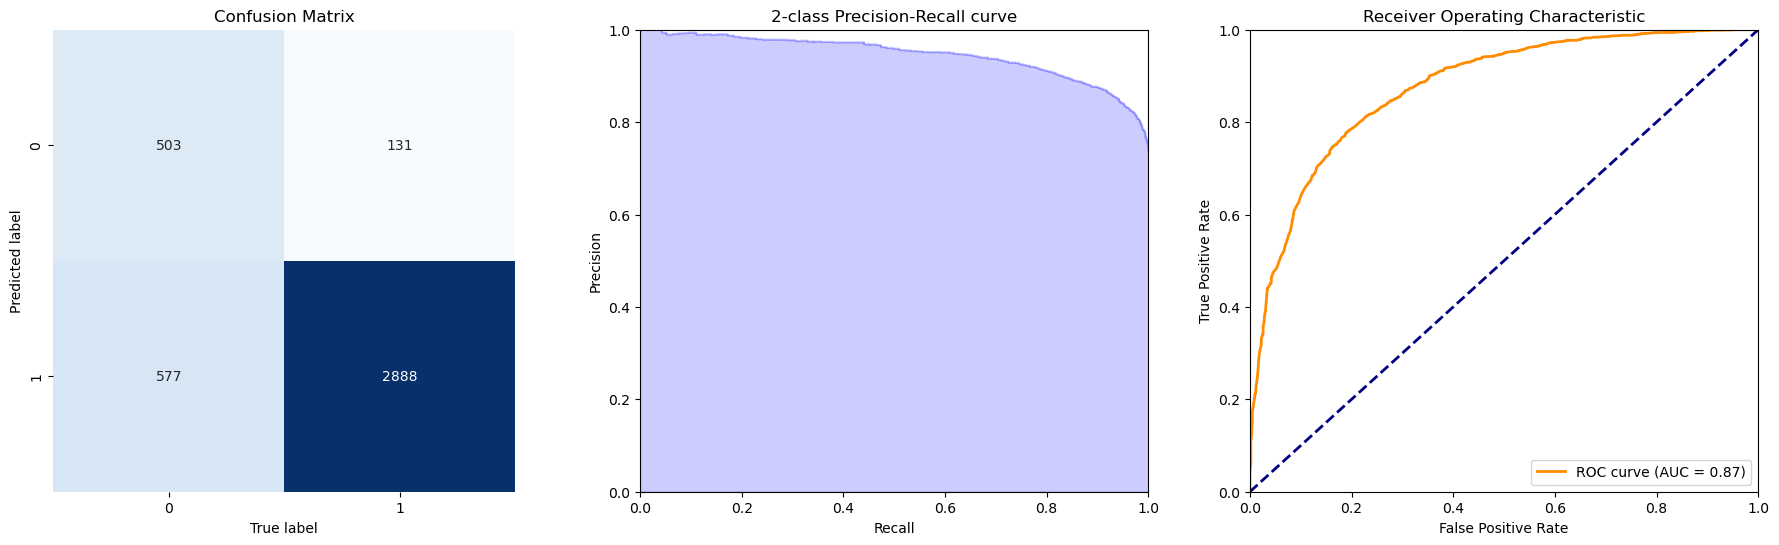

In [80]:
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test_mapped, predictions, probabilities)

**Random Forest feature importance plot**

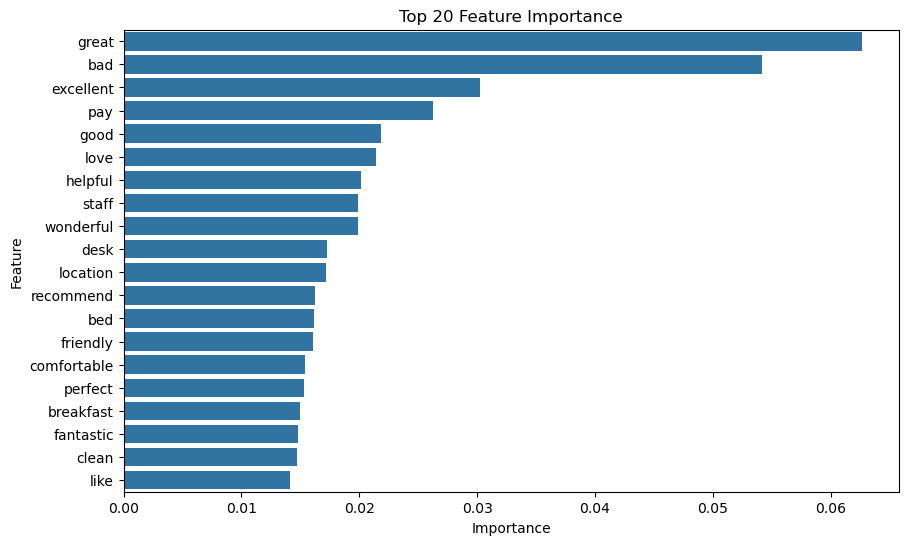

In [83]:
# Get feature importance from the classifier
importances = pipe.named_steps['classifier'].feature_importances_

# Get the feature names from the TF-IDF vectorizer
feature_names = pipe.named_steps['tfidf'].get_feature_names_out()

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 8: Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  # Show top 20 features
plt.title('Top 20 Feature Importance')
plt.savefig("rfc_feature_importance_plot.png")
plt.show()

#### 7.1.2 [OPTIONAL] Three class (negative, neutral and positive) prediction 

In [ ]:
# Initialize a dataframe to store results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

In [ ]:
def show_summary_report(actual, prediction, probabilities):
    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction, average='macro')  # Macro-averaged for multi-class
    recall_ = recall_score(actual, prediction, average='macro')        # Macro-averaged for multi-class
    roc_auc_ = roc_auc_score(actual, probabilities, multi_class='ovr', average='macro')

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [Macro-average across classes]' % precision_)
    print('Recall   : %.4f [Macro-average across classes]' % recall_)
    print('ROC AUC  : %.4f [OvR Macro-average]' % roc_auc_)
    print('-' * 107)

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Create subplots
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)

    # Plot Confusion Matrix
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Multi-class ROC curve (one-vs-rest)
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = probabilities.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actual == i, probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    for i in range(n_classes):
        ax[1].plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Multi-Class ROC Curve')
    ax[1].legend(loc='lower right')

    # Precision-Recall Curve for each class
    ax[2].set_title('Precision-Recall Curve')
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(actual == i, probabilities[:, i])
        ax[2].step(recall, precision, where='post', label=f'Class {i}')
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].legend(loc='lower left')

    plt.show()

    return accuracy_, precision_, recall_, roc_auc_

In [ ]:
label_map = {-1: 0, 0: 1, 1: 2}

y_train_mapped = y_train.map(label_map)
y_test_mapped = y_test.map(label_map)

In [ ]:
# Initialize the model
rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)

# Train the classifier with the training data
rf_clf.fit(X_train_tfidf, y_train_mapped)

# Make predictions on the test data
predictions = rf_clf.predict(X_test_tfidf)

# Store probabilities of predictions being 1
probabilities = rf_clf.predict_proba(X_test_tfidf)

In [ ]:
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test_mapped, predictions, probabilities)